## Homework #4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [2]:
cc = pd.read_csv('C:/Users/davej/.jupyter/mlzoomcamp/04-evaluation/aer_credit_card.csv')

###  Question 1

In [3]:
#mapping 'yes' to 1 and 'no' to 0 for card var
cc['card'] = (cc['card'] == 'yes').astype(int)

In [4]:
#setting up the validation framework
cc_full_train, cc_test = train_test_split(cc, test_size=0.2, random_state=1)
cc_train, cc_val = train_test_split(cc_full_train, test_size=0.25, random_state=1)

In [5]:
#reset indices for each data subset
cc_train = cc_train.reset_index(drop=True)
cc_val = cc_val.reset_index(drop=True)
cc_test = cc_test.reset_index(drop=True)

In [6]:
#creating vector for y vars
y_train = cc_train['card'].values
y_val = cc_val['card'].values
y_test = cc_test['card'].values

In [7]:
#delete card vars from subsets so that we don't accidentally use it as a feature to predict target var
del cc_train['card']
del cc_val['card']
del cc_test['card']

In [8]:
#creating numerical and categorical variable name lists
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'active']
categorical = [
    'owner',
    'selfemp',
    'majorcards'
]

In [9]:
#calculating roc auc using each numerical variable
for var in numerical:
    auc = roc_auc_score(y_train, cc_train[var])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -cc_train[var])
    print('%9s, %.3f' % (var, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
   active, 0.604


###  Question 2

In [10]:
#create train function
def train(df, y, C=1.0): #C = parameter tuning; smaller the C, stronger the regularization
    dicts =  df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000) #C = parameter tuning
    model.fit(X_train, y)
    return dv, model
dv, model = train(cc_train, y_train)

In [11]:
#create predict function
def predict(df, dv, model):
    dicts =  df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred
y_pred = predict(cc_val, dv, model)

In [12]:
#calculate roc auc
round(roc_auc_score(y_val, y_pred), 3)

0.995

###  Question 3

In [13]:
#evaluate model on all thresholds from 0.0 to 1.0 with step 0.01
scores = []
thresholds =  np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))
scores

[(0.0, 211, 53, 0, 0),
 (0.01, 211, 34, 0, 19),
 (0.02, 211, 31, 0, 22),
 (0.03, 211, 24, 0, 29),
 (0.04, 211, 22, 0, 31),
 (0.05, 211, 22, 0, 31),
 (0.06, 211, 19, 0, 34),
 (0.07, 211, 19, 0, 34),
 (0.08, 210, 18, 1, 35),
 (0.09, 210, 18, 1, 35),
 (0.1, 210, 17, 1, 36),
 (0.11, 210, 17, 1, 36),
 (0.12, 210, 17, 1, 36),
 (0.13, 210, 11, 1, 42),
 (0.14, 208, 9, 3, 44),
 (0.15, 208, 9, 3, 44),
 (0.16, 208, 7, 3, 46),
 (0.17, 208, 7, 3, 46),
 (0.18, 207, 6, 4, 47),
 (0.19, 207, 5, 4, 48),
 (0.2, 207, 5, 4, 48),
 (0.21, 207, 5, 4, 48),
 (0.22, 207, 5, 4, 48),
 (0.23, 207, 5, 4, 48),
 (0.24, 206, 5, 5, 48),
 (0.25, 206, 5, 5, 48),
 (0.26, 206, 5, 5, 48),
 (0.27, 206, 5, 5, 48),
 (0.28, 206, 5, 5, 48),
 (0.29, 206, 5, 5, 48),
 (0.3, 205, 5, 6, 48),
 (0.31, 205, 4, 6, 49),
 (0.32, 205, 4, 6, 49),
 (0.33, 205, 4, 6, 49),
 (0.34, 205, 2, 6, 51),
 (0.35000000000000003, 205, 1, 6, 52),
 (0.36, 205, 1, 6, 52),
 (0.37, 205, 1, 6, 52),
 (0.38, 205, 1, 6, 52),
 (0.39, 205, 1, 6, 52),
 (0.4, 205, 1, 6

In [14]:
#compute precision and recall for each threshold
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
cc_scores = pd.DataFrame(scores, columns=columns)
cc_scores['precision'] = cc_scores['tp'] / (cc_scores['tp'] + cc_scores['fp'])
cc_scores['recall'] = cc_scores['tp'] / (cc_scores['tp'] + cc_scores['fn'])

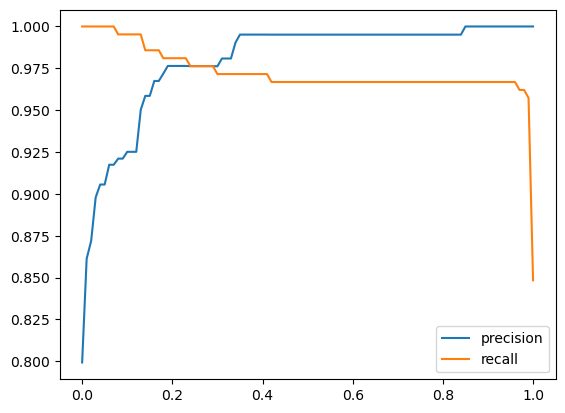

In [15]:
#plot precision and recall for each threshold
plt.plot(cc_scores['threshold'], cc_scores['precision'], label='precision')
plt.plot(cc_scores['threshold'], cc_scores['recall'], label='recall')
plt.legend()

###  Question 4

In [16]:
#compute f1 for each threshold
cc_scores['f1'] = (2 * cc_scores['precision'] * cc_scores['recall']) / (cc_scores['precision'] + cc_scores['recall'])
cc_scores.loc[cc_scores['f1'] == cc_scores['f1'].max()]

,threshold,tp,fp,fn,tn,precision,recall,f1
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213


###  Question 5

In [17]:
#train a model for each fold and calculate standard deviation of the auc scores across different folds
scores = []
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
for train_idx, val_idx in tqdm(kfold.split(cc_full_train), total=n_splits):
    cc_train = cc_full_train.iloc[train_idx]
    cc_val = cc_full_train.iloc[val_idx]
    y_train = cc_train['card'].values
    y_val = cc_val['card'].values
    dv, model = train(cc_train, y_train)
    y_pred = predict(cc_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

0.996 +- 0.003


###  Question 6

In [18]:
for C in tqdm([0.01, 0.1, 1, 10]):
    scores = []
    n_splits = 5
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    for train_idx, val_idx in tqdm(kfold.split(cc_full_train), total=n_splits):
        cc_train = cc_full_train.iloc[train_idx]
        cc_val = cc_full_train.iloc[val_idx]
        y_train = cc_train['card'].values
        y_val = cc_val['card'].values
        dv, model = train(cc_train, y_train, C=C)
        y_pred = predict(cc_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.1 0.995 +- 0.004


  0%|          | 0/5 [00:00<?, ?it/s]

C=1 0.996 +- 0.003


  0%|          | 0/5 [00:00<?, ?it/s]

C=10 0.996 +- 0.003
